# Import Modules and Data
ref: https://www.jianshu.com/p/0e1d51a7549d

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk

In [ ]:
PATH = "F:\colla\Documents\work\实习\RA\dataset"
df_hc = pd.read_excel('{}/EFSA_Approved_Health_Claims.xlsx'.format(PATH), header=None)
df_hc.columns = ['hc']
df_hc['hc'] = [e.replace('</p>','') for e in df_hc['hc']]
df_hc.head()

,hc
0,ALA contributes to the maintenance of normal b...
1,Activated charcoal contributes to reducing exc...
2,Barley grain fibre contributes to an increase ...
3,Beta-glucans contribute to the maintenance of ...
4,Betaine contributes to normal homocysteine met...


In [ ]:
df_hc = pd.read_excel('{}/Foodmaestro- Health Claim Data .xlsx'.format(PATH))
df_hc.columns = ['hc']
df_hc['hc'] = [e.replace('</p>','') for e in df_hc['hc']]
df_hc.head()

,hc
0,Bones: Vitamin D supports normal bones
1,Bones: Vitamin D supports the maintenance of...
2,Brain: DHA supports normal brain function
3,Calcium & Vitamin D support normal bones
4,DHA supports normal brain function


In [ ]:
df_hc.shape

(4198, 1)

# Tokenization

In [ ]:
# nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
word_tokens = word_tokenize(df_hc.hc[1])

print(sent_tokenize(df_hc.hc[1]))
print(word_tokens)

['  Bones: Vitamin D supports the maintenance of normal bones']
['Bones', ':', 'Vitamin', 'D', 'supports', 'the', 'maintenance', 'of', 'normal', 'bones']


In [ ]:
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [ ]:
tokenizer = TreebankWordTokenizer()
print(tokenizer.tokenize(df_hc.hc[239]))

['Black', 'Elderberry', 'contains', 'naturally', 'occurring', 'flavonoids', ',', 'along', 'with', 'Vitamin', 'C', '&', 'Zinc', 'which', 'contribute', 'to', 'the', 'protection', 'of', 'cells', 'from', 'oxidative', 'stress', '.']


# Stop Word
deleting stop words like conjunction and preposition 

In [ ]:
# nltk.download('stopwords')
from nltk.corpus import stopwords  # Stopwords corpus
filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
print(filtered_sent)

['Bones', ':', 'Vitamin', 'D', 'supports', 'maintenance', 'normal', 'bones']


# Stemming
Standardize words into a root format (might not be a real word), removing tenses and plural 's'

In [ ]:
from nltk.stem import PorterStemmer   
ps = PorterStemmer()
ps_stem_word = [ps.stem(word) for word in word_tokens]
print(ps_stem_word )

['ala', 'contribut', 'to', 'the', 'mainten', 'of', 'normal', 'blood', 'cholesterol', 'level', '.']


In [ ]:
from nltk.stem import SnowballStemmer   
snow = SnowballStemmer('english')
stem_words = [snow.stem(word) for word in word_tokens]
print(stem_words)

['ala', 'contribut', 'to', 'the', 'mainten', 'of', 'normal', 'blood', 'cholesterol', 'level', '.']


# POS tagging

In [ ]:
# nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(word_tokens)
print(tagged)

[('Bones', 'NNS'), (':', ':'), ('Vitamin', 'NNP'), ('D', 'NNP'), ('supports', 'VBZ'), ('the', 'DT'), ('maintenance', 'NN'), ('of', 'IN'), ('normal', 'JJ'), ('bones', 'NNS')]


In [ ]:
#create pos columns
df_hc['pos'] = [[i[1] for i in nltk.pos_tag(word_tokenize(s))] for s in df_hc.hc]

In [ ]:
def reduceSeq(l): # reduce repeated pos tags
    record = [x+1 for x,y in enumerate(l[1:]) if y == l[x]]
    l = l[:] #shallow copy
    for i in record[::-1]:
        l.pop(i)
        l[i-1] += '*'
    return l
df_hc['pos_reduced'] = list(map(reduceSeq, df_hc.pos))

In [ ]:
df_hc.head()

,hc,pos,pos_reduced
0,Bones: Vitamin D supports normal bones,"[NNS, :, NNP, NNP, VBZ, JJ, NNS]","[NNS, :, NNP*, VBZ, JJ, NNS]"
1,Bones: Vitamin D supports the maintenance of...,"[NNS, :, NNP, NNP, VBZ, DT, NN, IN, JJ, NNS]","[NNS, :, NNP*, VBZ, DT, NN, IN, JJ, NNS]"
2,Brain: DHA supports normal brain function,"[NN, :, NNP, VBZ, JJ, NN, NN]","[NN, :, NNP, VBZ, JJ, NN*]"
3,Calcium & Vitamin D support normal bones,"[NNP, CC, NNP, NNP, NN, JJ, NNS]","[NNP, CC, NNP*, NN, JJ, NNS]"
4,DHA supports normal brain function,"[NNP, VBZ, JJ, NN, NN]","[NNP, VBZ, JJ, NN*]"


In [ ]:
# Graph-based FP mining edges即为共现序列
def buildEdges(l, k=2, minS=10, raw=False):  
# l为输入的序列集合， k是序列中行为的个数 默认为2，minS是最小支持度 默认为10, 若raw为真返回原始全部dict数据
  edges = {}
  for s in l:
    s=s[:]
    s.insert(0,'s') # start notation
    for i in range(len(s)):
      if i+ k <= len(s):
        edge = '-'.join(s[i:i+k]) 
        if edge in edges:
          edges[edge] += 1
        else:
          edges[edge] = 1
  
  df_edges = pd.DataFrame(edges,index=['Support']).T.sort_values(by=['Support'],ascending=False)
  stat = {'TotalCombinations':len(df_edges),'min':df_edges['Support'].min(),
          'median':df_edges['Support'].median(),'mean':df_edges['Support'].mean(),
          'max':df_edges['Support'].max()
         }
  return (df_edges[df_edges['Support']>minS],pd.DataFrame([stat])) if raw==False else edges
# 输出为tuple, [0]项为dataframe结果，[1]为全部组合的统计数据

In [ ]:
buildEdges(df_hc.pos, 2, 50)[0]

,Support
JJ-NN,4037
NN-IN,3624
DT-NN,2305
s-NNP,2211
NN-NN,2057
NNP-NNP,2002
NN-CC,1947
IN-NN,1772
IN-JJ,1475
CC-NN,1455


In [ ]:
buildEdges(df_hc.pos, 3, 1000)[0]

,Support
DT-NN-IN,1425
NN-CC-NN,1207
DT-JJ-NN,1204
NN-IN-NN,1173
s-NNP-NNP,1080


In [ ]:
buildEdges(df_hc.pos, 4, 500)[0]

,Support
TO-DT-NN-IN,820
DT-JJ-NN-IN,658
DT-NN-IN-JJ,535
JJ-NN-IN-DT,533
s-NNP-NNP-VBZ,509
NN-IN-DT-NN,502


In [ ]:
buildEdges(df_hc.pos, 5, 300)[0]

,Support
DT-JJ-NN-IN-DT,415
VBZ-TO-DT-NN-IN,396
JJ-NN-IN-DT-NN,391
TO-DT-NN-IN-JJ,363
NN-IN-NN-CC-NN,330
NN-IN-DT-NN-NN,312
DT-NN-IN-JJ-NN,311
TO-DT-JJ-NN-IN,306


In [ ]:
buildEdges(df_hc.pos, 6, 200)[0]

,Support
DT-JJ-NN-IN-DT-NN,321
JJ-NN-IN-DT-NN-NN,308
DT-NN-IN-NN-CC-NN,278
TO-DT-JJ-NN-IN-DT,266
TO-DT-NN-IN-JJ-NN,233
TO-DT-NN-IN-NN-CC,215
NNP-VBZ-TO-DT-NN-IN,206


In [ ]:
buildEdges(df_hc.pos, 7, 100)[0]

,Support
DT-JJ-NN-IN-DT-NN-NN,265
TO-DT-JJ-NN-IN-DT-NN,232
TO-DT-NN-IN-NN-CC-NN,214
DT-NN-IN-NNS-IN-JJ-NN,138
TO-DT-NN-IN-NNS-IN-JJ,132
VBZ-TO-DT-JJ-NN-IN-DT,115
VBZ-TO-DT-NN-IN-JJ-NN,113
NNP-NNP-VBZ-TO-DT-NN-IN,103


In [ ]:
buildEdges(df_hc.pos, 8, 100)[0]

,Support
TO-DT-JJ-NN-IN-DT-NN-NN,191
TO-DT-NN-IN-NNS-IN-JJ-NN,132
VBZ-TO-DT-JJ-NN-IN-DT-NN,101


In [ ]:
buildEdges(df_hc.pos, 9, 100)[0]

,Support


In [ ]:
buildEdges(df_hc.pos, 10, 9)[0]

,Support
s-NNP-VBZ-TO-DT-NN-IN-JJ-NN-.,10


## Pos tagging test

In [ ]:
# nltk.download('state_union')
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
train_text = state_union.raw("2005-GWBush.txt")
sample_text = state_union.raw("2006-GWBush.txt")

In [ ]:
custom_sent_tokenizer = PunktSentenceTokenizer(train_text)
tokenized = custom_sent_tokenizer.tokenize(sample_text)

In [ ]:
def process_content():
    try:
        for i in tokenized[:2]:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            print(tagged)

    except Exception as e:
        print(str(e))

process_content()

[('PRESIDENT', 'NNP'), ('GEORGE', 'NNP'), ('W.', 'NNP'), ('BUSH', 'NNP'), ("'S", 'POS'), ('ADDRESS', 'NNP'), ('BEFORE', 'IN'), ('A', 'NNP'), ('JOINT', 'NNP'), ('SESSION', 'NNP'), ('OF', 'IN'), ('THE', 'NNP'), ('CONGRESS', 'NNP'), ('ON', 'NNP'), ('THE', 'NNP'), ('STATE', 'NNP'), ('OF', 'IN'), ('THE', 'NNP'), ('UNION', 'NNP'), ('January', 'NNP'), ('31', 'CD'), (',', ','), ('2006', 'CD'), ('THE', 'NNP'), ('PRESIDENT', 'NNP'), (':', ':'), ('Thank', 'NNP'), ('you', 'PRP'), ('all', 'DT'), ('.', '.')]
[('Mr.', 'NNP'), ('Speaker', 'NNP'), (',', ','), ('Vice', 'NNP'), ('President', 'NNP'), ('Cheney', 'NNP'), (',', ','), ('members', 'NNS'), ('of', 'IN'), ('Congress', 'NNP'), (',', ','), ('members', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('Supreme', 'NNP'), ('Court', 'NNP'), ('and', 'CC'), ('diplomatic', 'JJ'), ('corps', 'NN'), (',', ','), ('distinguished', 'JJ'), ('guests', 'NNS'), (',', ','), ('and', 'CC'), ('fellow', 'JJ'), ('citizens', 'NNS'), (':', ':'), ('Today', 'VB'), ('our', 'PRP$'), ('nat

# Chunking
by set Regular expression

In [ ]:
# state_union corpus example
def process_content():
    try:
        for i in tokenized[4:7]:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            chunkGram = r"""Chunk: {<RB.?>*<VB.?>*<NNP>+<NN>?}"""
            chunkParser = nltk.RegexpParser(chunkGram)
            chunked = chunkParser.parse(tagged)
            chunked.draw()     

    except Exception as e:
        print(str(e))

process_content()

In [ ]:
# test on health claims
tagged = nltk.pos_tag(nltk.word_tokenize(df_hc.hc[51]))
tagged

[('A', 'DT'),
 ('blend', 'NN'),
 ('of', 'IN'),
 ('vitamins', 'NNS'),
 ('including', 'VBG'),
 ('vitamin', 'NN'),
 ('B12', 'NNP'),
 ('to', 'TO'),
 ('reduce', 'VB'),
 ('fatigue', 'NN'),
 ('and', 'CC'),
 ('support', 'VB'),
 ('your', 'PRP$'),
 ('energy', 'NN'),
 ('yielding', 'VBG'),
 ('metabolism', 'NN'),
 ('.', '.')]

In [ ]:
# chunkGram = r"""Chunk: {<RB.?>*<VB.?>*<NNP>+<NN>?}"""
chunkGram = r"""Chunk: {<NNP>*<NN>*<NNS>?}"""
chunkParser = nltk.RegexpParser(chunkGram)
chunked = chunkParser.parse(tagged)
chunked.draw()     

In [ ]:
for subtree in chunked.subtrees():
    print(subtree)

(S
  (Chunk Vitamin/NNP D/NNP)
  supports/VBZ
  normal/JJ
  (Chunk bones/NNS))
(Chunk Vitamin/NNP D/NNP)
(Chunk bones/NNS)


In [ ]:
for subtree in chunked.subtrees(filter=lambda t: t.label() == 'Chunk'):
    print(subtree)

(Chunk fats/NNS)
(Chunk fats/NNS)
(Chunk diet/NN)
(Chunk blood/NN cholesterol/NN)
(Chunk High/NNP cholesterol/NN)
(Chunk risk/NN factor/NN)
(Chunk development/NN)
(Chunk heart/NN disease/NN)


In [ ]:
# Chinking delete some word
chunkGram = r"""Chunk: {<.*>+}
                                    }<VB.?|IN|DT|TO>+{"""
#从缝隙中删除一个或多个动词，介词，限定词或to这个词。

In [ ]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)
chunked = cp.parse(tagged)
chunked.draw()  

In [ ]:
for subtree in chunked.subtrees():
    print(subtree)

(S
  Replacing/VBG
  saturated/VBD
  (NP fats/NNS)
  (PP with/IN (NP unsaturated/JJ fats/NNS))
  (PP in/IN (NP the/DT diet/NN))
  has/VBZ
  been/VBN
  shown/VBN
  to/TO
  lower/reduce/VB
  (NP blood/NN cholesterol/NN)
  ./.
  (NP High/NNP cholesterol/NN)
  is/VBZ
  (NP a/DT risk/NN factor/NN)
  (PP in/IN (NP the/DT development/NN))
  (PP of/IN (NP coronary/JJ heart/NN disease/NN))
  ./.)
(NP fats/NNS)
(PP with/IN (NP unsaturated/JJ fats/NNS))
(NP unsaturated/JJ fats/NNS)
(PP in/IN (NP the/DT diet/NN))
(NP the/DT diet/NN)
(NP blood/NN cholesterol/NN)
(NP High/NNP cholesterol/NN)
(NP a/DT risk/NN factor/NN)
(PP in/IN (NP the/DT development/NN))
(NP the/DT development/NN)
(PP of/IN (NP coronary/JJ heart/NN disease/NN))
(NP coronary/JJ heart/NN disease/NN)


## Chunking example

In [ ]:
# nltk.download('conll2000')
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt')[99])

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\colla\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2000.zip.


(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


In [ ]:
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


In [ ]:
cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


In [ ]:
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


In [ ]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [ ]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unigram_chunker = UnigramChunker(train_sents)
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


In [ ]:
postags = sorted(set(pos for sent in train_sents for (word,pos) in sent.leaves()))
print(unigram_chunker.tagger.tag(postags))

[('#', 'B-NP'), ('$', 'B-NP'), ("''", 'O'), ('(', 'O'), (')', 'O'), (',', 'O'), ('.', 'O'), (':', 'O'), ('CC', 'O'), ('CD', 'I-NP'), ('DT', 'B-NP'), ('EX', 'B-NP'), ('FW', 'I-NP'), ('IN', 'O'), ('JJ', 'I-NP'), ('JJR', 'B-NP'), ('JJS', 'I-NP'), ('MD', 'O'), ('NN', 'I-NP'), ('NNP', 'I-NP'), ('NNPS', 'I-NP'), ('NNS', 'I-NP'), ('PDT', 'B-NP'), ('POS', 'B-NP'), ('PRP', 'B-NP'), ('PRP$', 'B-NP'), ('RB', 'O'), ('RBR', 'O'), ('RBS', 'B-NP'), ('RP', 'O'), ('SYM', 'O'), ('TO', 'O'), ('UH', 'O'), ('VB', 'O'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'B-NP'), ('WP', 'B-NP'), ('WP$', 'B-NP'), ('WRB', 'O'), ('``', 'O')]


# Named Entity Recognition

In [ ]:
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
def process_content():
    try:
        for i in tokenized[:3]:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            namedEnt = nltk.ne_chunk(tagged, binary=True)
            namedEnt.draw()
    except Exception as e:
        print(str(e))

process_content()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\colla\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\colla\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


In [ ]:
tagged = nltk.pos_tag(nltk.word_tokenize(df_hc.hc[2]))
tagged

[('Barley', 'NNP'),
 ('grain', 'NN'),
 ('fibre', 'NN'),
 ('contributes', 'VBZ'),
 ('to', 'TO'),
 ('an', 'DT'),
 ('increase', 'NN'),
 ('in', 'IN'),
 ('faecal', 'JJ'),
 ('bulk', 'NN'),
 ('.', '.')]

In [ ]:
namedEnt = nltk.ne_chunk(tagged, binary=True)
namedEnt.draw()

# Lemmatizing
Stemmed word might not be a real word, lemmatizing would standardise the word.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('wordnet')

In [ ]:
lemmatizer = WordNetLemmatizer()
# transform to noun by default
print(lemmatizer.lemmatize("cats"))
print(lemmatizer.lemmatize("cacti"))
print(lemmatizer.lemmatize("geese"))
print(lemmatizer.lemmatize("rocks"))
print(lemmatizer.lemmatize("python"))
print(lemmatizer.lemmatize("better", pos="a"))
print(lemmatizer.lemmatize("best", pos="a"))
print(lemmatizer.lemmatize("run"))
print(lemmatizer.lemmatize("run",'v'))
print(lemmatizer.lemmatize("running"))
print(lemmatizer.lemmatize("studied"))
print(lemmatizer.lemmatize("known","v"))
print(lemmatizer.lemmatize("actively"))

cat
cactus
goose
rock
python
good
best
run
run
running
studied
know
actively


In [ ]:
# Word net lemmatizer use a diffferent pos tag from penn-tree bank
def get_wordnet_pos(treebank_tag):
#     treebank_tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(treebank_tag[0], wordnet.NOUN)

lemmatized_word = [lemmatizer.lemmatize(i[0],get_wordnet_pos(i[1])) for i in tagged]
lemmatized_word

['Activated',
 'charcoal',
 'contributes',
 'to',
 'reduce',
 'excessive',
 'flatulence',
 'after',
 'eat',
 '.']

In [ ]:
tagged

[('Activated', 'VBN'),
 ('charcoal', 'NN'),
 ('contributes', 'NNS'),
 ('to', 'TO'),
 ('reducing', 'VBG'),
 ('excessive', 'JJ'),
 ('flatulence', 'NN'),
 ('after', 'IN'),
 ('eating', 'VBG'),
 ('.', '.')]

# Synonyms & antonyms

In [ ]:
syns = wordnet.synsets("program")
print(syns[0].name())

plan.n.01


In [ ]:
print(syns[0].lemmas()[0].name())


plan


In [ ]:
# defination
print(syns[0].definition())

a series of steps to be carried out or goals to be accomplished


In [ ]:
synonyms = []
antonyms = []

for syn in wordnet.synsets("good"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())

print(set(synonyms))
print(set(antonyms))

{'unspoiled', 'upright', 'respectable', 'adept', 'ripe', 'goodness', 'honest', 'undecomposed', 'full', 'near', 'just', 'effective', 'honorable', 'skillful', 'dear', 'in_effect', 'expert', 'estimable', 'dependable', 'soundly', 'skilful', 'trade_good', 'in_force', 'practiced', 'good', 'well', 'unspoilt', 'secure', 'commodity', 'salutary', 'serious', 'beneficial', 'sound', 'safe', 'proficient', 'right', 'thoroughly'}
{'bad', 'evilness', 'evil', 'badness', 'ill'}


In [ ]:
synonyms = []
antonyms = []

for syn in wordnet.synsets("bad"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())

print(set(synonyms))
print(set(antonyms))

{'bad', 'tough', 'speculative', 'risky', 'uncollectible', 'unfit', 'spoiled', 'unsound', 'forged', 'spoilt', 'big', 'badness', 'badly', 'defective', 'high-risk', 'sorry', 'regretful'}
{'goodness', 'unregretful', 'good'}


# Semantic similarity between words

In [ ]:
wordnet.synsets("love")

[Synset('love.n.01'),
 Synset('love.n.02'),
 Synset('beloved.n.01'),
 Synset('love.n.04'),
 Synset('love.n.05'),
 Synset('sexual_love.n.02'),
 Synset('love.v.01'),
 Synset('love.v.02'),
 Synset('love.v.03'),
 Synset('sleep_together.v.01')]

In [ ]:
w3 = wordnet.synset('love.n.01')
w4 = wordnet.synset('love.n.04')
w3.definition(),w4.definition()

('a strong positive emotion of regard and affection',
 'a deep feeling of sexual desire and attraction')

In [ ]:
print(w3.wup_similarity(w4))

0.6666666666666666


# Text Features

In [ ]:
all_hc_words = []
for s in df_hc.hc:
    all_hc_words.extend(nltk.word_tokenize(s))
all_words = nltk.FreqDist(all_hc_words)
len(all_hc_words),len(all_words)

(62021, 1778)

In [ ]:
print(all_words.most_common(15))

[('to', 3088), ('and', 3059), ('of', 3044), ('the', 2609), ('normal', 2390), (',', 1890), ('Vitamin', 1328), ('contributes', 1217), ('in', 1006), ('function', 928), ('a', 833), ('which', 806), ('C', 754), ('system', 740), ('maintenance', 674)]


In [ ]:
hc_len = [len(i) for i in df_hc.hc]
print('Max vocabs in health claims:',np.max(hc_len))
print('Mean vocabs in health claims:',np.round(np.mean(hc_len),3))
print('Median vocabs in health claims:',np.median(hc_len))
print('Min vocabs in health claims:',np.min(hc_len))

Max vocabs in health claims: 483
Mean vocabs in health claims: 85.592
Median vocabs in health claims: 75.0
Min vocabs in health claims: 7


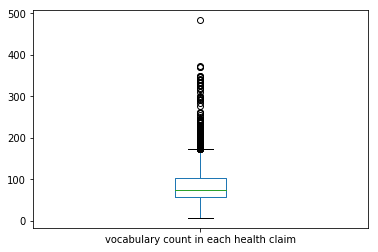

In [ ]:
pd.DataFrame(pd.Series(hc_len).sort_values().values,columns=['vocabulary count in each health claim']).plot.box()

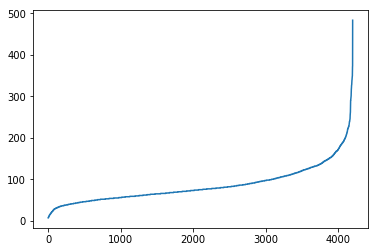

In [ ]:
pd.Series(pd.Series(hc_len).sort_values().values).plot()

In [ ]:
all_words

FreqDist({'to': 3088, 'and': 3059, 'of': 3044, 'the': 2609, 'normal': 2390, ',': 1890, 'Vitamin': 1328, 'contributes': 1217, 'in': 1006, 'function': 928, ...})

In [ ]:
pd.DataFrame(all_words.most_common(30))

,0,1
0,to,3088
1,and,3059
2,of,3044
3,the,2609
4,normal,2390
5,",",1890
6,Vitamin,1328
7,contributes,1217
8,in,1006
9,function,928


In [ ]:
len(all_hc_words)

62021

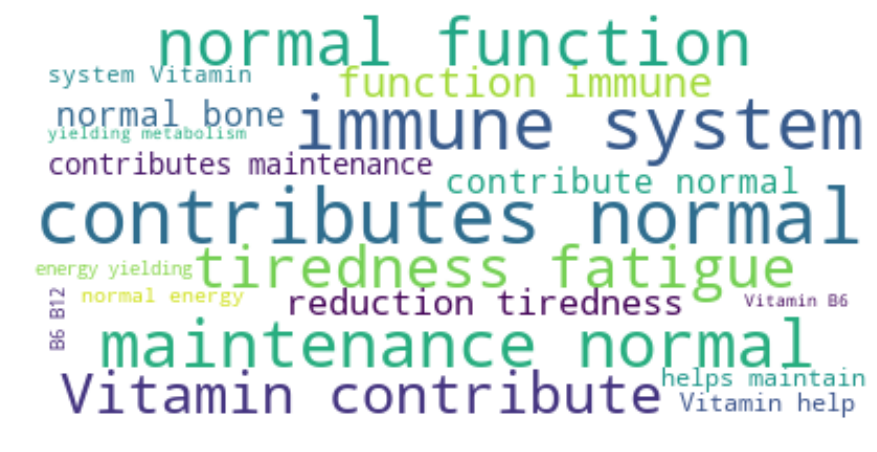

In [ ]:
# word cloud
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
# % matplotlib inline

wordcloud = WordCloud(max_font_size=300, min_font_size=8, max_words=50, background_color="white").generate(' '.join(all_hc_words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Text word corpus
all_text = nltk.Text(w.lower() for w in state_union.words())
all_text.similar('man')

NameError: name 'state_union' is not defined

In [ ]:
all_hc_text = nltk.Text([w.lower() for w in all_hc_words])
all_hc_text.similar('vitamin')

vitamins and iron zinc magnesium calcium protein c manganese selenium
biotin copper riboflavin niacin iodine d vit dha which folate


In [ ]:
all_hc_text.similar('contributes')

contribute helps and help contributing vitamin zinc d iron proven
iodine supports dha calcium protein magnesium needed helping known
essential


In [ ]:
#Return collocations derived from the text, ignoring stopwords.
all_hc_text.collocation_list(10, 2)

['immune system',
 'oxidative stress',
 'yielding metabolism',
 'energy yielding',
 'normal function',
 'balanced diet',
 'nervous system',
 'folic acid',
 'muscle mass',
 'fatty acids']

In [ ]:
#Find contexts where the specified words appear; list most frequent common contexts first.
all_hc_text.common_contexts(['contributes'], num=20)

d_to which_to eggs_to vitamin_to which_towards dha_to fibre_to fat_to
and_to a_to zinc_to iron_to ala_to omega_to acid_to vitamins_to
metabolism_to system_to c_to biotin_to


In [ ]:
all_hc_text.concordance('contributes', width=50 , lines=20)

Displaying 20 of 1317 matches:
munity : vitamin d contributes to the normal func
uscles : vitamin d contributes to the maintenance
activity vitamin d contributes to the normal func
of vitamin a which contributes to the normal func
muscle tone 2 eggs contributes to : normal brain 
ga 3 ( dha ) which contributes to baby 's brain a
ga 3 ( dha ) which contributes to normal brain an
0 % rda vitamin b6 contributes to normal energy y
henic acid , which contributes towards normal men
ke of 250mg of dha contributes to maintenance of 
0mg of epa and dha contributes to the normal func
 high in rye fibre contributes to normal bowel fu
w in saturated fat contributes to the maintenance
ce of biotin which contributes to normal macronut
ce of iron ! which contributes to the reduction o
 potassium ! which contributes to normal blood pr
e of protein which contributes to a grow in muscl
e of protein which contributes to a growth in mus
 of thiamine which contributes to normal energy y
 of thiamine which 

In [ ]:
all_hc_text.count('contributes')

1317

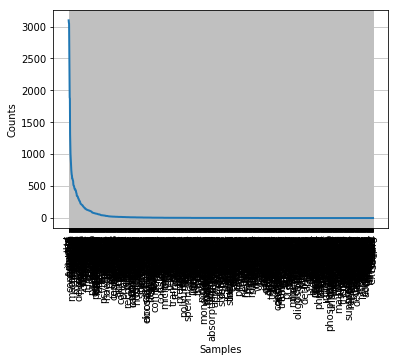

In [ ]:
all_hc_text.plot() # nltk.FreqDist(all_words).plot()

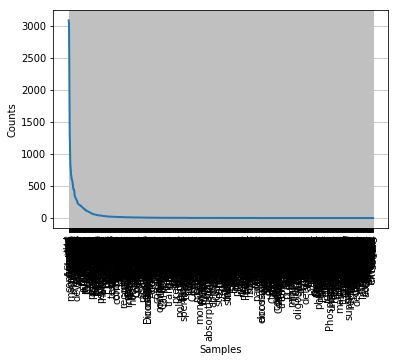

In [ ]:
all_words.plot()

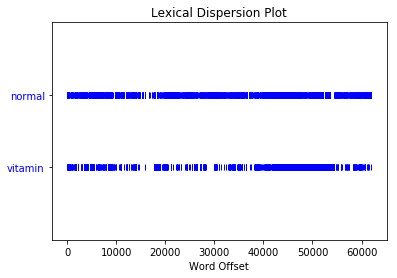

In [ ]:
all_hc_text.dispersion_plot(['normal','vitamin'])
#Produce a plot showing the distribution of the words through the text. Requires pylab to be installed.

In [ ]:
all_hc_text.vocab()

FreqDist({'.': 257, 'to': 238, 'of': 213, 'contributes': 209, 'the': 195, 'normal': 186, 'maintenance': 66, 'vitamin': 57, 'in': 51, 'blood': 46, ...})

In [ ]:
all_hc_text.findall("<normal>(<.*>)")

blood; blood; homocysteine; energy-yielding; functioning;
macronutrient; psychological; hair; mucous; skin; blood; energy-
yielding; muscle; neurotransmission; function; bones; teeth; brain;
blood; digestion; homocysteine; lipid; liver; macronutrient; blood;
connective; energy-yielding; functioning; hair; iron; skin; function;
blood; blood; brain; blood; vision; bowel; function; amino; blood;
homocysteine; psychological; function; blood; blood; blood; cognitive;
energy-yielding; functioning; skin; production; thyroid; cognitive;
energy-yielding; formation; oxygen; function; blood; energy-yielding;
functioning; muscle; protein; psychological; bones; teeth; energy-
yielding; bones; formation; sulphur; blood; energy-yielding;
functioning; psychological; mucous; skin; energy-yielding; mental;
synthesis; blood; energy-yielding; function; bones; teeth; blood;
functioning; muscle; blood; bones; blood; blood; blood; blood; energy-
yielding; functioning; mucous; red; skin; vision; metabolism; b

In [ ]:
all_hc_text.findall("<a.*>{2,}")

alpha-cyclodextrin as; arabinoxylan as; amino acid; an acceleration;
amino acid; and after; an acceleration; age and; acids are a; acids
are


In [ ]:
all_hc_text.index('contribute')

33

In [ ]:
all_hc_words[33]

'contribute'

In [ ]:
all_hc_text.tagged_words()

AttributeError: 'Text' object has no attribute 'tagged_words'

# Topic Modelling (Latent Dirichlet allocation)

In [ ]:
def tokenize(text):
    lda_tokens = []
    tokens = word_tokenize(text)
    for token in tokens:
        if token != '.':
            lda_tokens.append(token.lower())
    return lda_tokens

token = tokenize(df_hc.hc[1])
print(token)

['bones', ':', 'vitamin', 'd', 'supports', 'the', 'maintenance', 'of', 'normal', 'bones']


In [ ]:
# lemmatizing/ get the root word
# nltk.download('wordnet')
from nltk.corpus import wordnet
def get_lemma(word):
    lemma = wordnet.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)
get_lemma(token[2])

'vitamin'

In [ ]:
# stop words
en_stop = set(nltk.corpus.stopwords.words('english'))

In [ ]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
#     tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [ ]:
import random
text_data = []
for hc in df_hc.hc:
    tokens = prepare_text_for_lda(hc)
#     if random.random() > .99:
#         print(tokens)
    text_data.append(tokens)

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [ ]:
import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.088*"protein" + 0.050*"high" + 0.042*"heart"')
(1, '0.140*"normal" + 0.104*"function" + 0.098*"system"')
(2, '0.084*"fibre" + 0.083*"contain" + 0.073*"brain"')
(3, '0.120*"help" + 0.120*"healthy" + 0.066*"vitamin"')
(4, '0.108*"cell" + 0.103*"contribute" + 0.092*"oxidative"')
(5, '0.155*"zinc" + 0.103*"normal" + 0.080*"skin"')
(6, '0.099*"vitamin" + 0.092*"," + 0.058*"tiredness"')
(7, '0.072*"blood" + 0.059*"acid" + 0.056*"normal"')
(8, '0.082*"development" + 0.081*"growth" + 0.067*"normal"')
(9, '0.155*"level" + 0.107*"blood" + 0.083*"fat"')
(10, '0.156*"normal" + 0.117*"metabolism" + 0.095*"contribute"')
(11, '0.094*"bones" + 0.078*"normal" + 0.076*"vitamin"')


In [ ]:
new_doc = df_hc.hc[23]
new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc) #转换为token id, token count格式

print(' '.join(new_doc))
print(new_doc_bow)
print(ldamodel.get_document_topics(new_doc_bow))

1 pot delicious soup source vitamin contribute normal function immune system
[(2, 1), (4, 1), (8, 1), (26, 1), (27, 1), (29, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)]
[(1, 0.3484775), (10, 0.5820213)]


# Visualizing Topics

In [ ]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

E:\Anaconda\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
